In [1]:
from notebook_tools import *
%matplotlib inline

In [75]:
columns = ['Q2' , 'Xb' , 'p/q' ,'theta (pq)' , 'Mmiss' ,'Pmiss3Mag','pcmX','pcmY','pcmZ' , 'rooWeight']

PmissBins = [[0.3,0.45]  , [0.45,0.55] , [0.55,0.65] , [0.65,0.75] , [0.75,1.0]]
Pmiss = [0.5*(PmissBins[i][0]+PmissBins[i][1]) for i in range(len(PmissBins))]

colors = ['black','red','blue']
markers = ['v','o','s']
directions = ['x','y']#,'z'] # z is not interesting at the moment
markers_direction = [['v','o'],['s','^']]

# pp-SRC analysis in different cuts

In [3]:
def get_mean_and_sigma( x , w ):

    mean_unweighted , mean_weighted = np.average( x ) , np.average( x , weights=w )
    sigma_unweighted, sigma_weighted= np.sqrt(np.average( np.square(x-mean_unweighted) )) , np.sqrt(np.average( np.square(x-mean_weighted) , weights=w  ))            

    return mean_unweighted , mean_weighted , sigma_unweighted, sigma_weighted



def cm_parameters_in_pmiss_bins(ana,do_prints=False):
    df_pMissBins = pd.DataFrame()
    for i in range(len(PmissBins)):
        pMiss_min , pMiss_max = PmissBins[i][0] , PmissBins[i][1]


        ana_reduced = ana[ (pMiss_min < ana.Pmiss3Mag) & (ana.Pmiss3Mag < pMiss_max) ]
        if do_prints: 
            print 'p(miss) bin ',i,',',pMiss_min,' to ',pMiss_max,' GeV/c, ',len(ana),'events in this bin'

        sqrtN = sqrt(len(ana_reduced))
        mX, mX_weighted, sX, sX_weighted = get_mean_and_sigma( x=ana_reduced.pcmX , w=ana_reduced.rooWeight )
        mY, mY_weighted, sY, sY_weighted = get_mean_and_sigma( x=ana_reduced.pcmY , w=ana_reduced.rooWeight )
        mZ, mZ_weighted, sZ, sZ_weighted = get_mean_and_sigma( x=ana_reduced.pcmZ , w=ana_reduced.rooWeight )
            
        df_pMissBin = pd.DataFrame({'bin':i
                                    ,'mean_x_unweighted':mX   ,'mean_xErr_unweighted':sX/sqrtN 
                                    ,'sigma_x_unweighted':sX,'sigma_xErr_unweighted':0.02 # resolution uncertainty                                    
                                    ,'mean_y_unweighted':mY   ,'mean_yErr_unweighted':sY/sqrtN 
                                    ,'sigma_y_unweighted':sY,'sigma_yErr_unweighted':0.02 # resolution uncertainty
                                    ,'mean_z_unweighted':mZ   ,'mean_zErr_unweighted':sZ/sqrtN 
                                    ,'sigma_z_unweighted':sZ,'sigma_zErr_unweighted':0.02 # resolution uncertainty
                                    ,'mean_x_weighted':mX_weighted       ,'mean_xErr_weighted':sX_weighted/sqrtN    
                                    ,'sigma_x_weighted':sX_weighted    ,'sigma_xErr_weighted':0.02 # resolution uncertainty  
                                    ,'mean_y_weighted':mY_weighted       ,'mean_yErr_weighted':sY_weighted/sqrtN
                                    ,'sigma_y_weighted':sY_weighted    ,'sigma_yErr_weighted':0.02 # resolution uncertainty
                                    ,'mean_z_weighted':mZ_weighted       ,'mean_zErr_weighted':sZ_weighted/sqrtN   
                                    ,'sigma_z_weighted':sZ_weighted    ,'sigma_zErr_weighted':0.02 # resolution uncertainty
                                   } , index=[i])

        df_pMissBins = df_pMissBins.append(df_pMissBin)
        
    return df_pMissBins



In [4]:
def get_cm_parameters( Xbmin = None,
                      theta_pq_max = None ,
                      p_over_q_min = None , p_over_q_max = None, 
                      MmissMax = None ,
                      target='C12',
                      cut_name='nominal_cuts',
                      do_prints=False
                     ):

    ana_nom = read_root( "/Users/erezcohen/Desktop/DataMining/AnaFiles/Ana_ppSRCcut_DATA_%s.root"%target , key='anaTree' , columns=columns  )
    ana_mod = read_root( "/Users/erezcohen/Desktop/DataMining/AnaFiles/Ana_relaxed_ppSRCCut_DATA_%s.root"%target , key='anaTree' , columns=columns  )
    ana_mod = ana_mod[ (Xbmin < ana_mod.Xb) 
                      & (ana_mod['theta (pq)'] < theta_pq_max) 
                      & (p_over_q_min < ana_mod['p/q'])
                      & (ana_mod['p/q'] < p_over_q_max) 
                      & (ana_mod['Mmiss'] < MmissMax)  ]

    df_p_miss_bins_nom = cm_parameters_in_pmiss_bins(ana_nom)
    df_p_miss_bins_mod = cm_parameters_in_pmiss_bins(ana_mod)

    if do_prints:
        print target
        print cut_name
        print df_p_miss_bins_nom
        print df_p_miss_bins_mod

    return df_p_miss_bins_nom , df_p_miss_bins_mod


In [5]:
def plot_fit2constant(x=None , y=None , yerr=None , color='black' , do_plot_result=True, alpha=0.1 , xtext=None, ytext=None):

    simga2_inverse = [1./np.square(yerr[i]) if yerr[i]>0.01 else 0.01 for i in range(len(x))]
    mean = np.average(y , weights=simga2_inverse)
    sigma = np.sqrt(np.average(np.square(y-mean),weights=simga2_inverse))
    y , yerr = mean*np.ones(len(x)) , sigma*np.ones(len(x))      
    plt.plot( x , y , '-',color=color)
    plt.fill_between( x , y-yerr , y+yerr , color=color , alpha=alpha)

    if do_plot_result:
        if xtext is None:
            xtext = np.min(x) + 0.1*(np.max(x)-np.min(x))
        if ytext is None:
            ytext = np.min(y) + 0.1*(np.max(y)-np.min(y))
        plt.text(xtext , ytext , '$%.3f \\pm %.3f $'%(mean,sigma) + '%', color=color , fontsize=20) 

    return mean , sigma

In [145]:
def fit_cm_nom_mod(var='sigma',var_label="$\sigma_{c.m.}$ [GeV/c]",
                     Xbmin = [1.2,1.2],
                     theta_pq_max = [25,25] ,                     
                     p_over_q_min = [0.62,0.62] , p_over_q_max = [0.96,0.96] ,                      
                     MmissMax = [1.10,1.10] ,
                     modified_cut_name='Xb115Xb125',
                     nominal_and_modified_cut_names=['$x_B>1.2$','$x_B>1.15$','$x_B>1.25$'] ,
                   target='C12', target_name='$^{12}$C',
                     do_prints=False,
                     do_make_plot=True,
                     do_save_plots=False):

    cm_mod_arr , cm_diff  = [] , [] 

    for i in range(2):
        cm_nom,cm_mod = get_cm_parameters(target=target,
                                          Xbmin=Xbmin[i],
                                          theta_pq_max=theta_pq_max[i],
                                          p_over_q_min=p_over_q_min[i],p_over_q_max=p_over_q_max[i],
                                          MmissMax=MmissMax[i],
                                          do_prints=do_prints,
                                          cut_name=nominal_and_modified_cut_names[1+i])
        for direction in directions:
            for cm_nom_par , cm_mod_par in zip(np.array(cm_nom[var+'_'+direction+'_unweighted']),np.array(cm_mod[var+'_'+direction+'_unweighted'])):
                cm_diff.append(cm_mod_par-cm_nom_par)
            
        cm_mod_arr.append(cm_mod)
            
    #     print 'cm_diff:',cm_diff
    mean_diff = np.average(cm_diff)
    sigma_diff = np.std(cm_diff)
    
        
    if do_make_plot:
        
        fig = plt.figure(figsize=(16,8))
        ax = fig.add_subplot(1,1,1)
        # nominal c.m.
        for i,color,marker,direction in zip(range(2),colors,markers,directions):
            plt.errorbar(Pmiss, 
                         cm_nom[var+'_'+direction+'_unweighted'], yerr=cm_nom[var+'_'+direction+'Err_unweighted'],
                         color=color, marker=marker , linestyle='none' , label=None , markersize=10,alpha=0.2)
        # modified c.m.
        i_mod = 0
        for cm_mod in cm_mod_arr:
            if i_mod==0:
                label=None
            else:
                label=direction+' direction'
            for i,color,direction in zip(range(2),colors,directions):
                plt.errorbar(Pmiss-0.005*(i_mod+1)*(i+1)*np.ones(len(Pmiss)), 
                             cm_mod[var+'_'+direction+'_unweighted'], yerr=cm_mod[var+'_'+direction+'Err_unweighted'],
                             color=color, marker=markers_direction[i_mod][i] , linestyle='none' , 
                             label=nominal_and_modified_cut_names[i_mod+1]+','+direction+' direction' , markersize=10)
            i_mod = i_mod+1
            
#         plot_fit2constant(x=Pmiss , y=y , yerr=yerr , color=color , ytext=ytext)


        ax.grid()
        ax.legend(fontsize=25,loc='best')
        ax.set_title('%s, %s vs. %s/%s '%(target_name,nominal_and_modified_cut_names[0],nominal_and_modified_cut_names[1],nominal_and_modified_cut_names[2])
                     , fontsize=25 , y=1.04)
        set_axes(ax , x_label='' , y_label=var_label , fontsize=30)
        set_axes(ax , x_label=r'$|\vec{p}_{miss}|$ [GeV/c]' , y_label="", fontsize=30)
#         ax.xaxis.set_major_formatter( NullFormatter() )

        
#         ax = fig.add_subplot(2,1,2)
#         set_axes(ax,x_label=r'$\sigma^{nominal}_{c.m.} - \sigma^{modified}_{c.m.}$ [GeV/c]',y_label="counts", fontsize=30)
#         h,bins,_=plt.hist(cm_diff)
#         plt.text(np.min(bins)-0.005,0.8*np.max(h),'$%.3f \pm %.3f$ GeV/c'%(mean_diff,sigma_diff),fontsize=25)
#         ax.set_xlim(np.min(bins)-0.01,np.max(bins)+0.01)
#         ax.set_ylim(0,1.05*np.max(h))


#         plt.subplots_adjust(hspace=0)        
        plt.tight_layout()
        if do_save_plots:
            fig.savefig("/Users/erezcohen/Desktop/DataMining/AccCorr_ppSRCAnalysisNote/all_figures/cm_sensitivity/cm_sensitivity_%s_%s_%s.pdf"%(var,modified_cut_name,target))
        return mean_diff , sigma_diff , cm_diff

-------
C12 
-------
sigma
xB>1.2 sigma(transverse) cut sensitivity: 0.008 GeV/c
theta_pq<25 sigma(transverse) cut sensitivity: 0.010 GeV/c
0.62<p/q<0.97 sigma(transverse) cut sensitivity: 0.010 GeV/c
Mmiss<1.1 sigma(transverse) cut sensitivity: 0.010 GeV/c
tot. syst. uncertainty tranverse (sigma): 0.019 GeV/c
-------
Al27 
-------
sigma
xB>1.2 sigma(transverse) cut sensitivity: 0.020 GeV/c
theta_pq<25 sigma(transverse) cut sensitivity: 0.009 GeV/c
0.62<p/q<0.97 sigma(transverse) cut sensitivity: 0.011 GeV/c
Mmiss<1.1 sigma(transverse) cut sensitivity: 0.018 GeV/c
tot. syst. uncertainty tranverse (sigma): 0.030 GeV/c
-------
Fe56 
-------
sigma
xB>1.2 sigma(transverse) cut sensitivity: 0.007 GeV/c
theta_pq<25 sigma(transverse) cut sensitivity: 0.007 GeV/c
0.62<p/q<0.97 sigma(transverse) cut sensitivity: 0.007 GeV/c
Mmiss<1.1 sigma(transverse) cut sensitivity: 0.013 GeV/c
tot. syst. uncertainty tranverse (sigma): 0.017 GeV/c
-------
Pb208 
-------
sigma
xB>1.2 sigma(transverse) cut sens

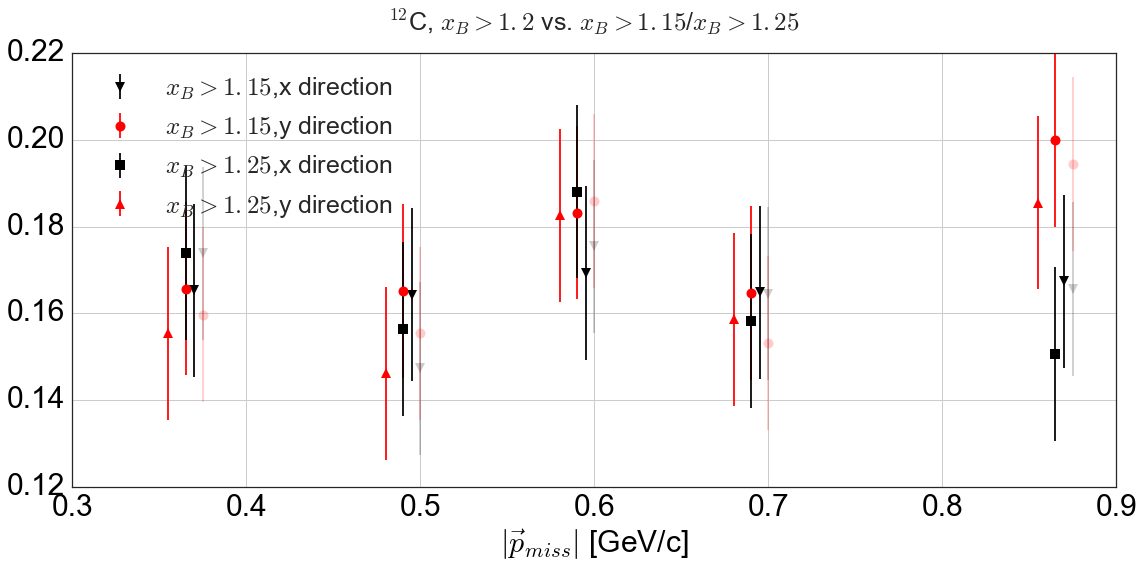

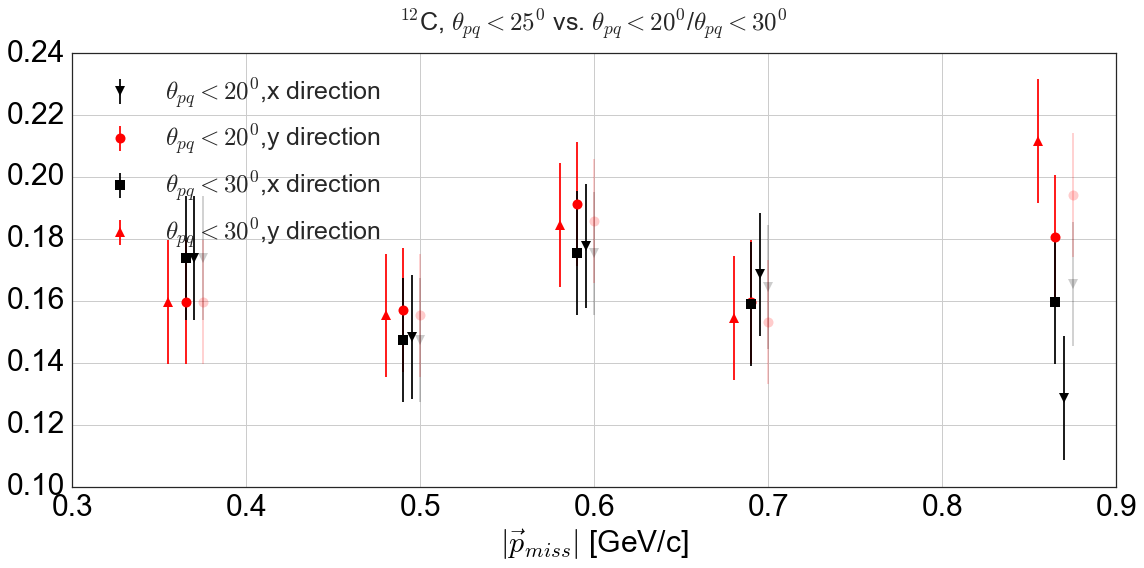

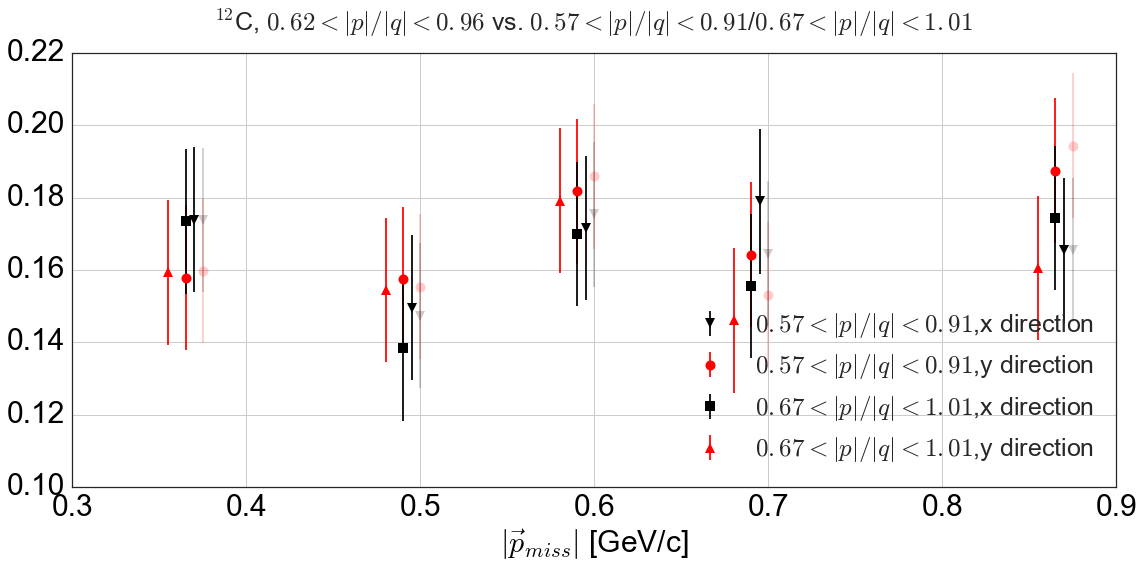

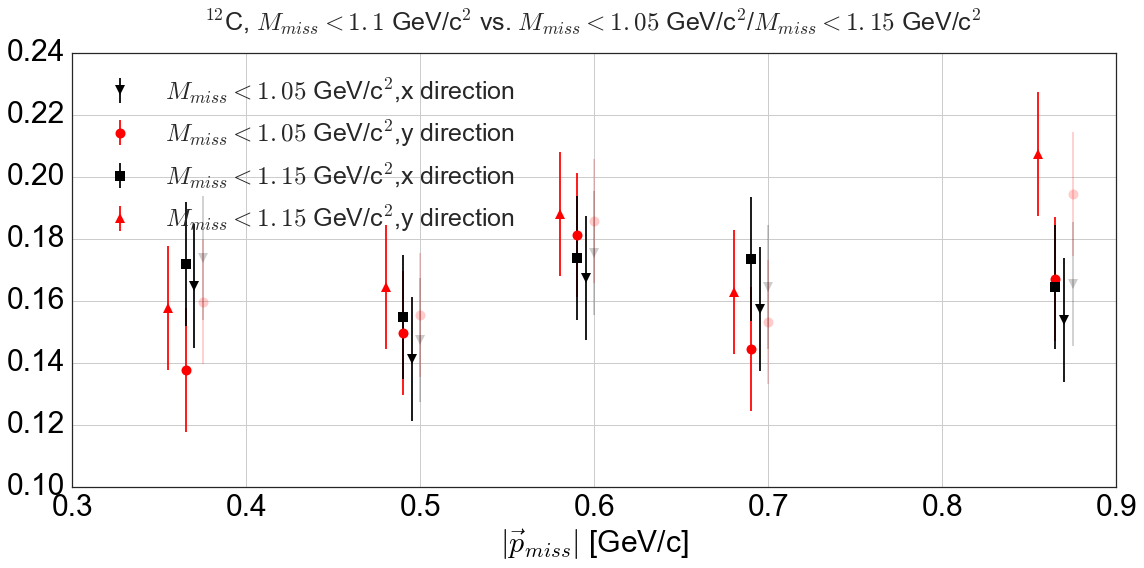

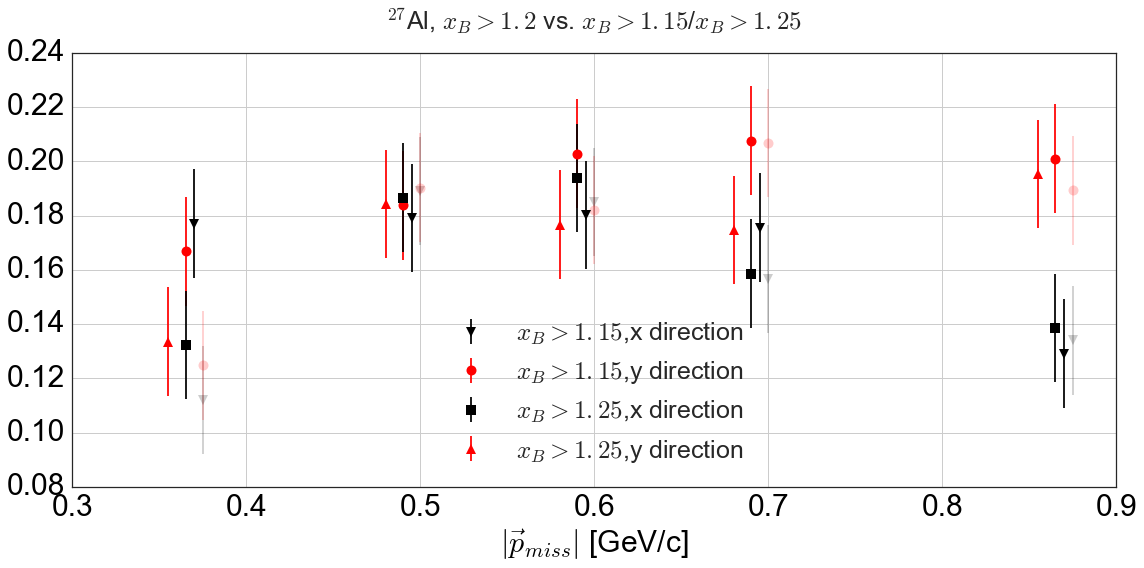

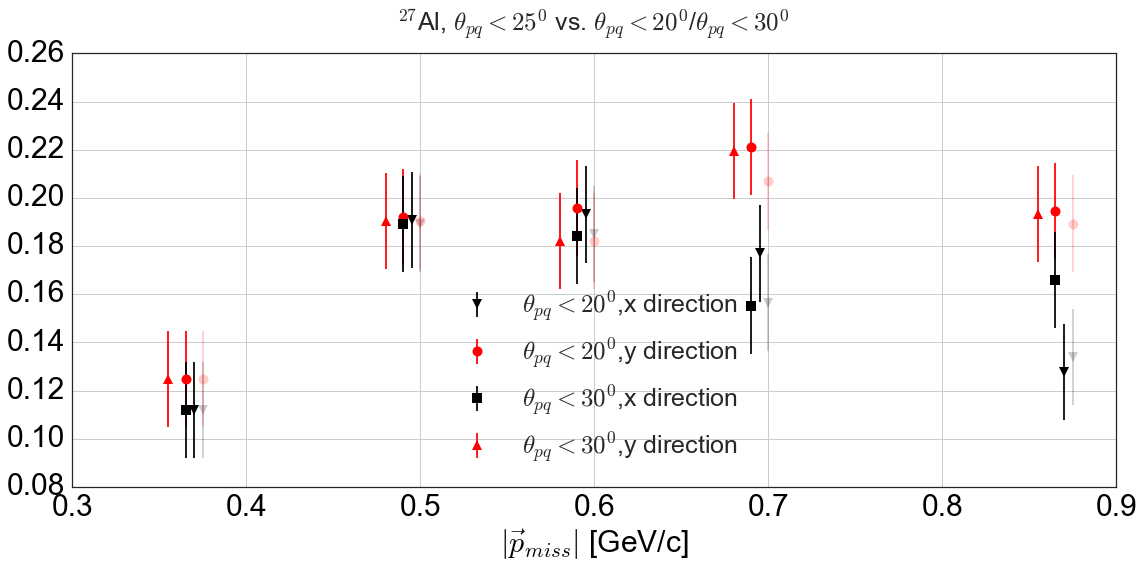

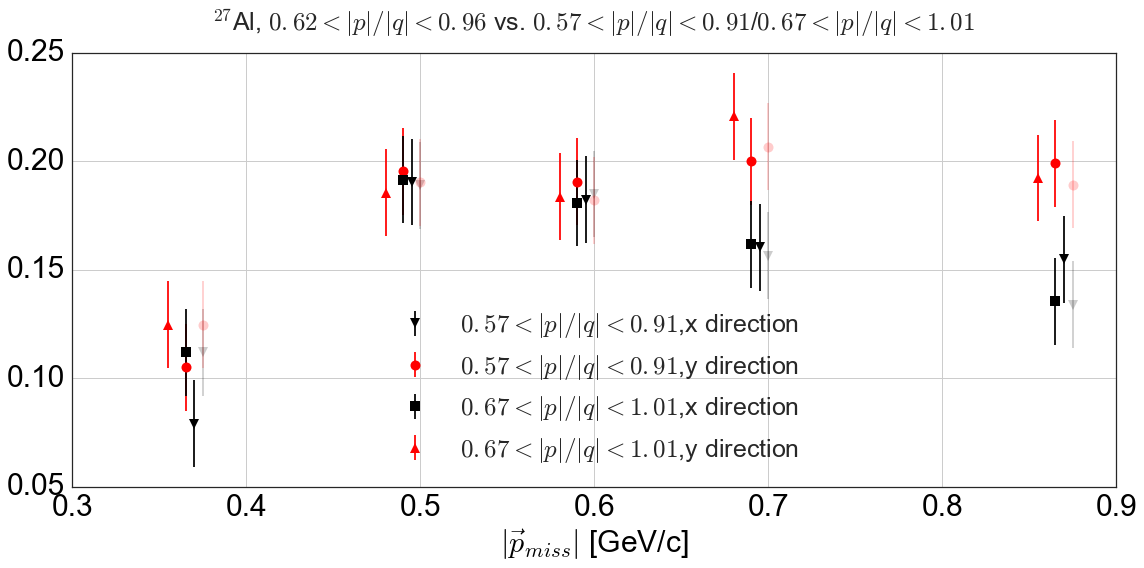

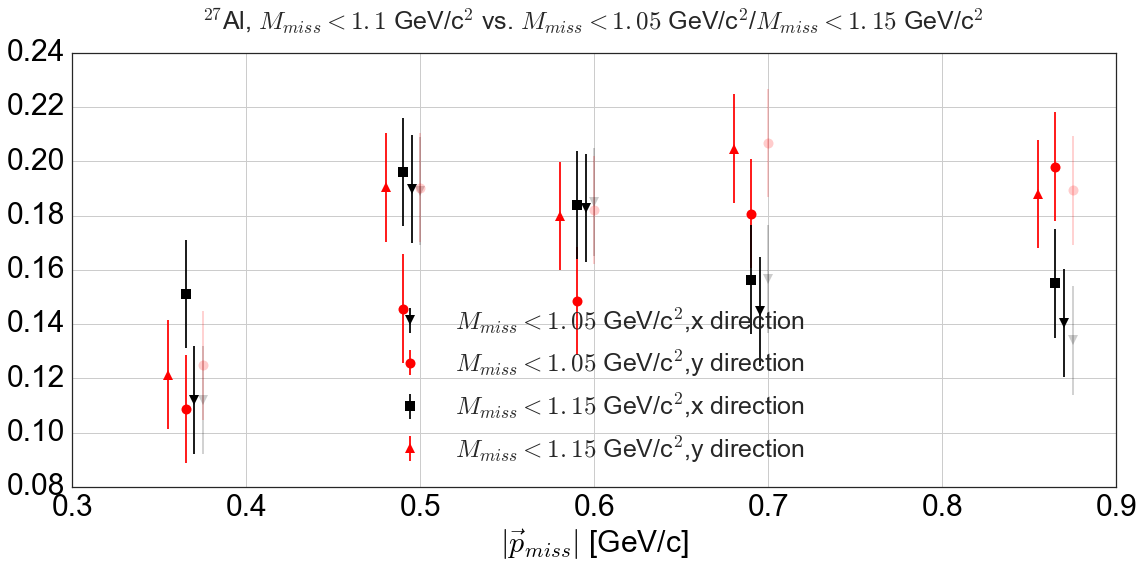

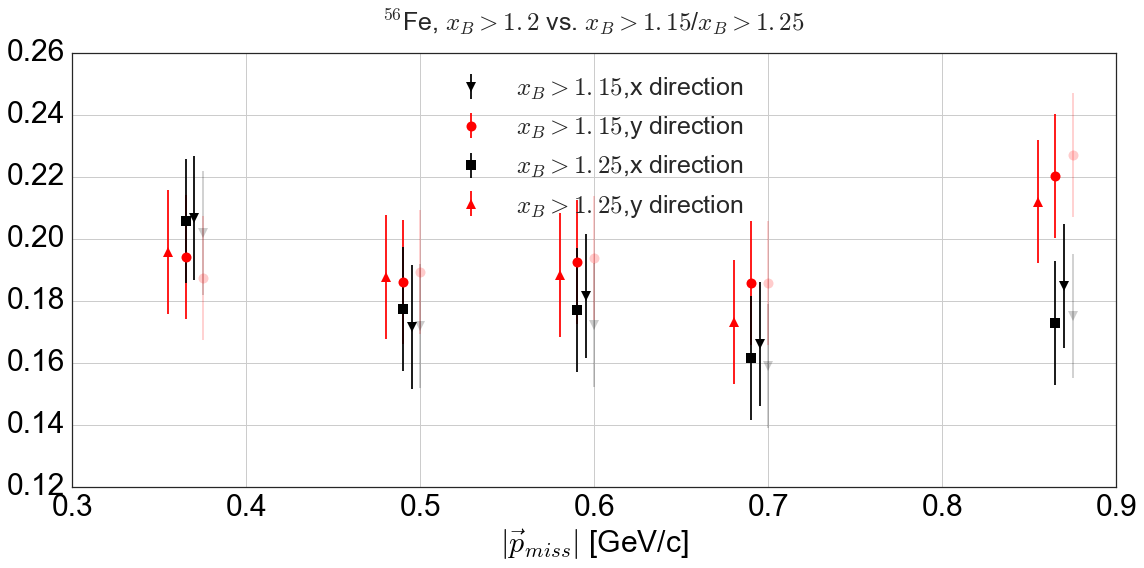

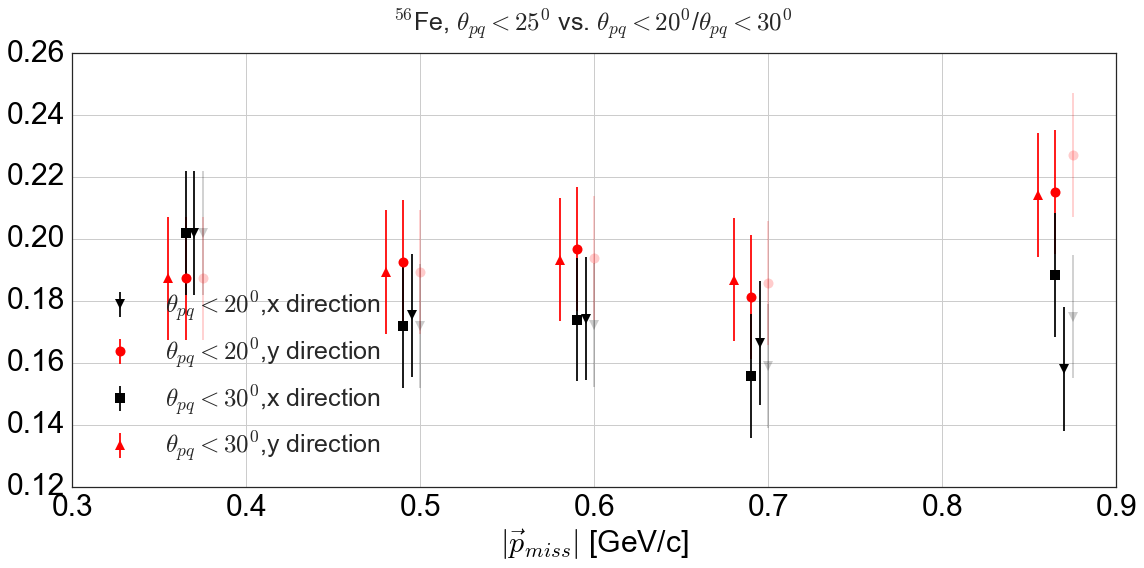

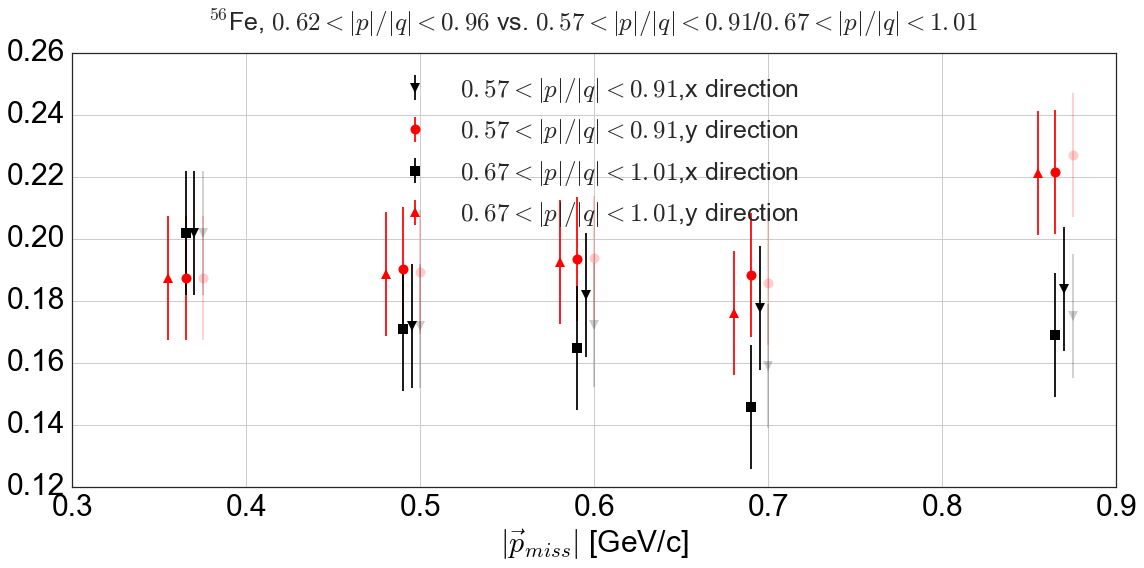

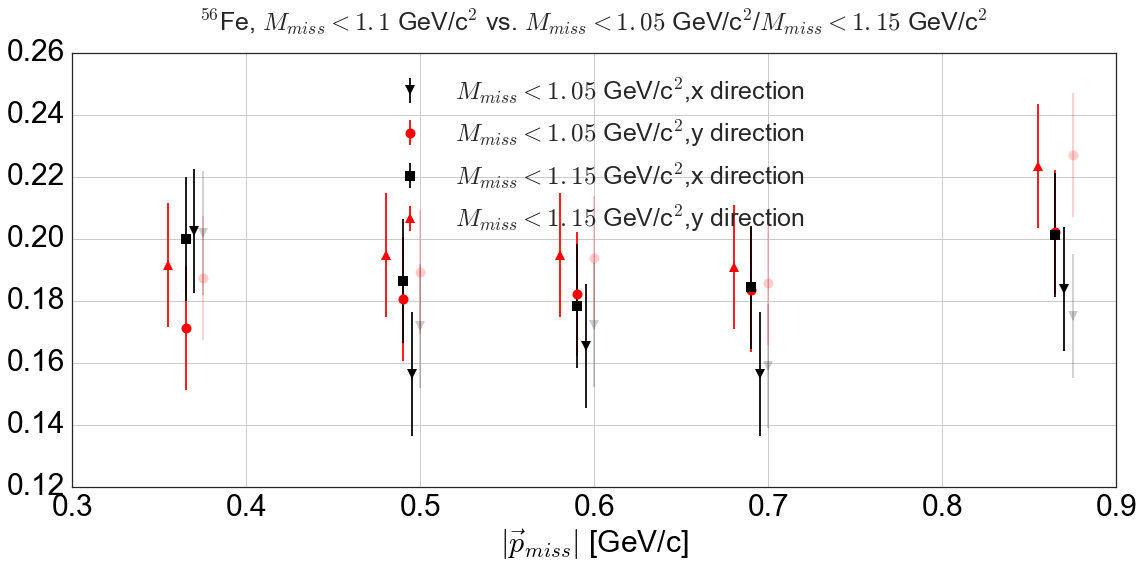

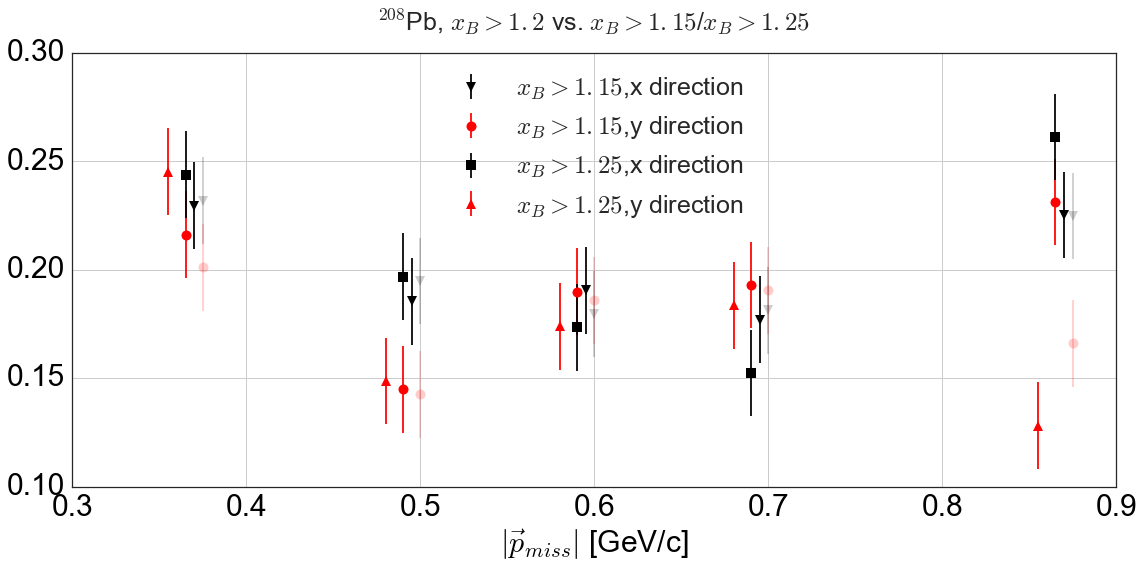

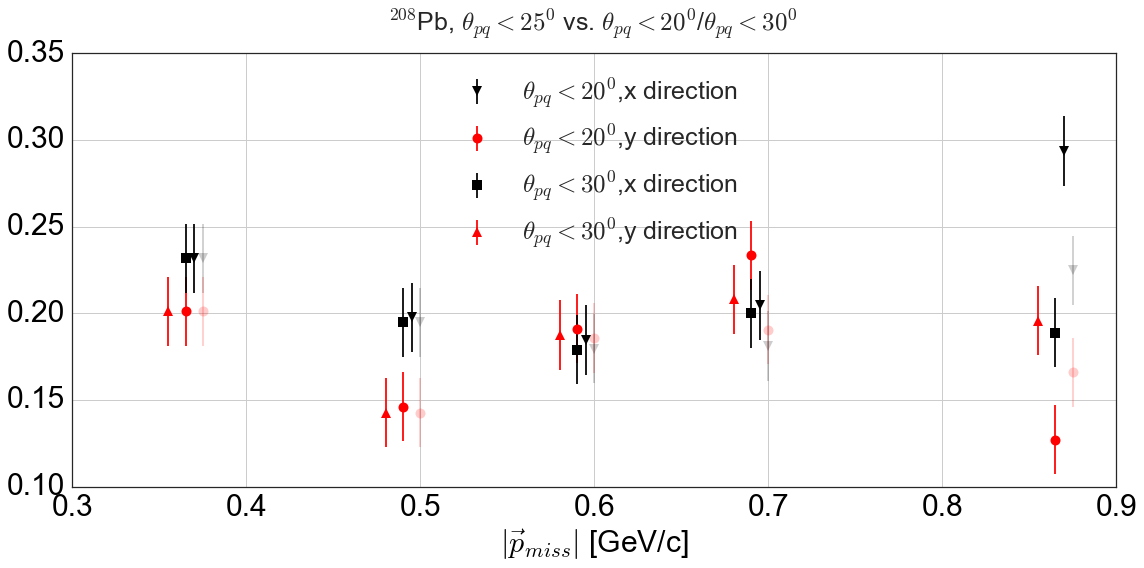

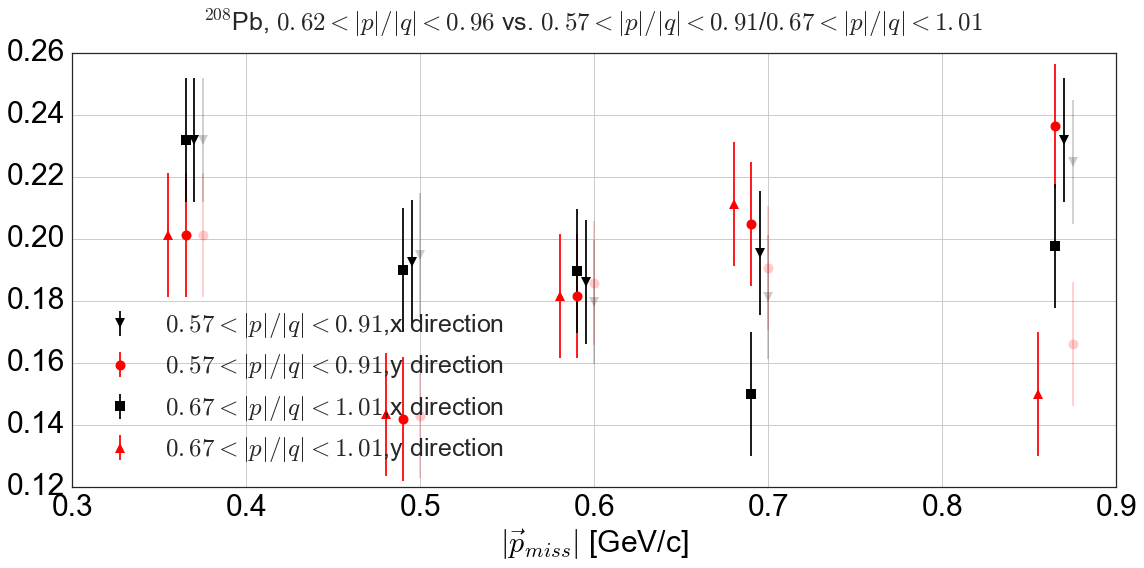

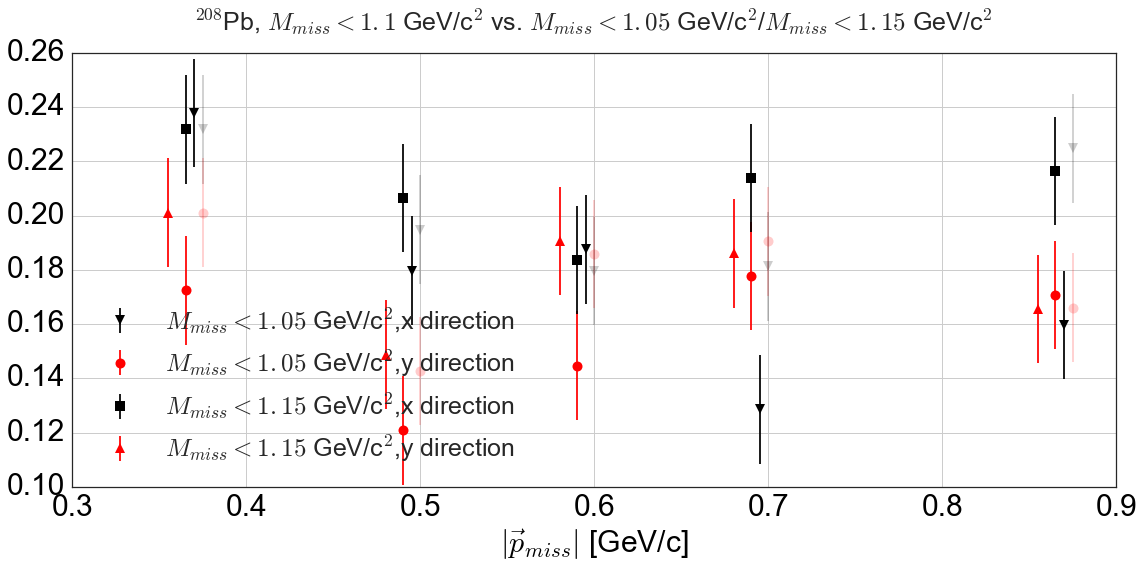

In [146]:
do_make_plot = True
do_save_plots = True
targets = ['C12','Al27','Fe56','Pb208']
target_names = ['$^{12}$C','$^{27}$Al','$^{56}$Fe','$^{208}$Pb'] 
variables = ['sigma']#,'mean']
var_names = ["$\sigma_{c.m.}$ [GeV/c]"]#,"$\mu_{c.m.}$ [GeV/c]"]

df_cm_diff = pd.DataFrame()
i_target=0
for target,target_name in zip(targets,target_names):
    print '-------\n',target,'\n-------'
    for var,var_label in zip(variables,var_names):
        print var
        
        mean_Xb , sigma_Xb , cm_diff_Xb = fit_cm_nom_mod(Xbmin = [1.15,1.25],                                                  
                                            modified_cut_name='Xb115Xb125',                                            
                                            nominal_and_modified_cut_names=['$x_B>1.2$','$x_B>1.15$','$x_B>1.25$'],                                            
                                            target=target,target_name=target_name,do_prints=False,do_make_plot=do_make_plot,                                            
                                            do_save_plots=do_save_plots,var=var,var_label=var_label)
        sensitivity_t_Xb = np.max([mean_Xb , sigma_Xb])
        print 'xB>1.2 %s(transverse) cut sensitivity: %.3f GeV/c'%(var,sensitivity_t_Xb)


        mean_theta_pq , sigma_theta_pq , cm_diff_theta_pq = fit_cm_nom_mod(theta_pq_max=[20,30],                                                                                                                           
                                                        modified_cut_name='theta_pq_20_theta_pq_30',
                                                        nominal_and_modified_cut_names=['$\\theta_{pq}<25^{0}$','$\\theta_{pq}<20^{0}$','$\\theta_{pq}<30^{0}$'],
                                                        target=target,target_name=target_name,do_prints=False,do_make_plot=do_make_plot,                                                                                                                      
                                                        do_save_plots=do_save_plots,var=var,var_label=var_label)

        sensitivity_t_theta_pq = np.max([mean_theta_pq , sigma_theta_pq])
        print 'theta_pq<25 %s(transverse) cut sensitivity: %.3f GeV/c'%(var,sensitivity_t_theta_pq)



        mean_p_over_q , sigma_p_over_q , cm_diff_p_over_q = fit_cm_nom_mod(p_over_q_min=[0.57,0.67],p_over_q_max=[0.91,1.01],
                                                        modified_cut_name='p_over_q_057_091_p_over_q_067_101',                                                        
                                                        nominal_and_modified_cut_names=['$0.62<|p|/|q|<0.96$','$0.57<|p|/|q|<0.91$','$0.67<|p|/|q|<1.01$'],                                                                                                       
                                                        target=target,target_name=target_name,do_prints=False,do_make_plot=do_make_plot,                                                        
                                                        do_save_plots=do_save_plots,var=var,var_label=var_label)
        sensitivity_t_p_over_q = np.max([mean_p_over_q , sigma_p_over_q ])
        print '0.62<p/q<0.97 %s(transverse) cut sensitivity: %.3f GeV/c'%(var,sensitivity_t_p_over_q)


 
        mean_mmiss , sigma_mmiss , cm_diff_mmiss = fit_cm_nom_mod(MmissMax=[1.05,1.15],                                 
                                                  modified_cut_name='mmiss1050_mmiss1150',                                                                                                            
                                                  nominal_and_modified_cut_names=['$M_{miss}<1.1$ GeV/c$^2$','$M_{miss}<1.05$ GeV/c$^2$','$M_{miss}<1.15$ GeV/c$^2$'],                                                  
                                                  target=target,target_name=target_name,do_prints=False,do_make_plot=do_make_plot,                                                  
                                                  do_save_plots=do_save_plots,var=var,var_label=var_label)
        sensitivity_t_mmiss = np.max([mean_mmiss , sigma_mmiss])
        print 'Mmiss<1.1 %s(transverse) cut sensitivity: %.3f GeV/c'%(var,sensitivity_t_mmiss)

        print 'tot. syst. uncertainty tranverse ('+var+'): %.3f GeV/c'%np.sqrt(np.square(sensitivity_t_Xb) 
                                                                         + np.square(sensitivity_t_theta_pq)
                                                                         + np.square(sensitivity_t_p_over_q) 
                                                                         + np.square(sensitivity_t_mmiss))


        cm_diff = []
        for i in range(len(cm_diff_Xb)):
            cm_diff.append(cm_diff_Xb[i])
        for i in range(len(cm_diff_theta_pq)):
            cm_diff.append(cm_diff_theta_pq[i])
        for i in range(len(cm_diff_p_over_q)):
            cm_diff.append(cm_diff_p_over_q[i])
        for i in range(len(cm_diff_mmiss)):
            cm_diff.append(cm_diff_mmiss[i])
        df_cm_diff[target]=cm_diff
        i_target = i_target+1
        

In [134]:
# plt.hist(df_cm_diff['C12']);
def hist_diff(cm_diff=df_cm_diff['C12']):
    mean_diff = np.average(cm_diff)
    sigma_diff = np.std(cm_diff)
    fig,ax = plt.subplots(figsize=(15,10))
    set_axes(ax,x_label=r'$\sigma^{nominal}_{c.m.} - \sigma^{modified}_{c.m.}$ [GeV/c]',y_label="counts", fontsize=30)
    h,bins,_ = plt.hist(cm_diff)
    plt.text(np.min(bins)-0.005,0.8*np.max(h),'$%.3f \pm %.3f$ GeV/c'%(mean_diff,sigma_diff),fontsize=25)
    ax.set_xlim(np.min(bins)-0.01,np.max(bins)+0.01)
    ax.set_ylim(0,1.05*np.max(h))





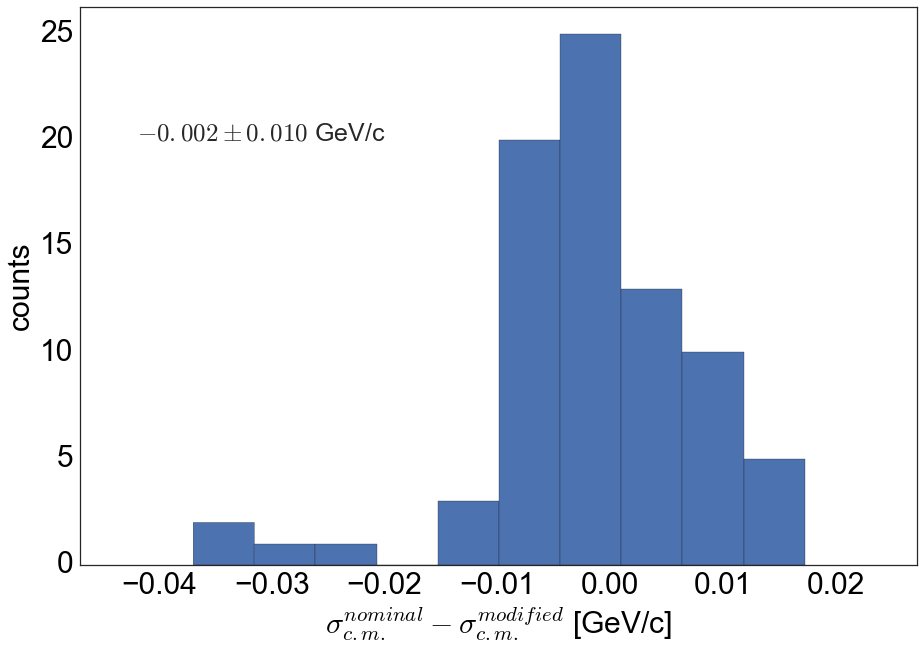

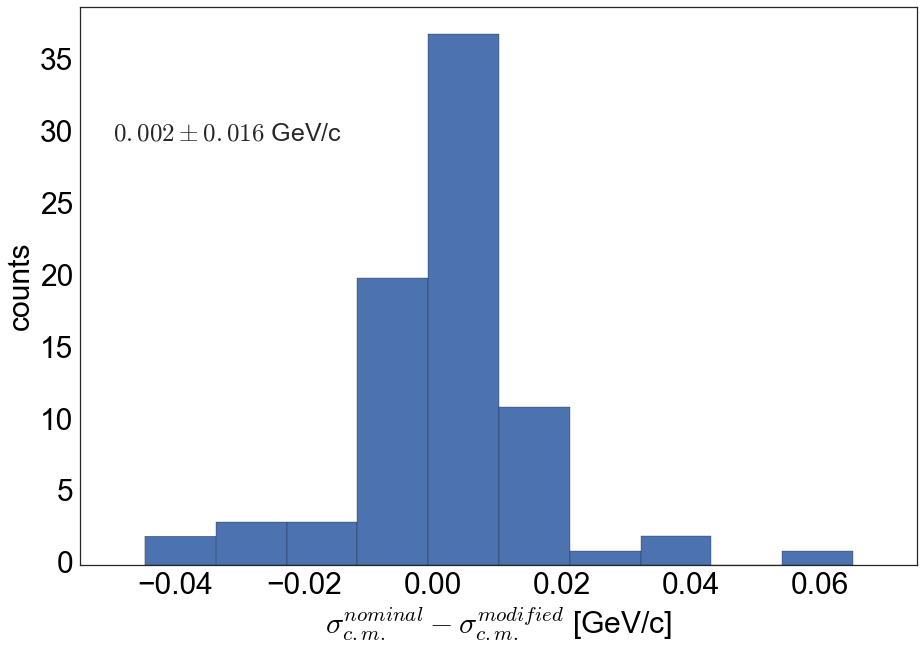

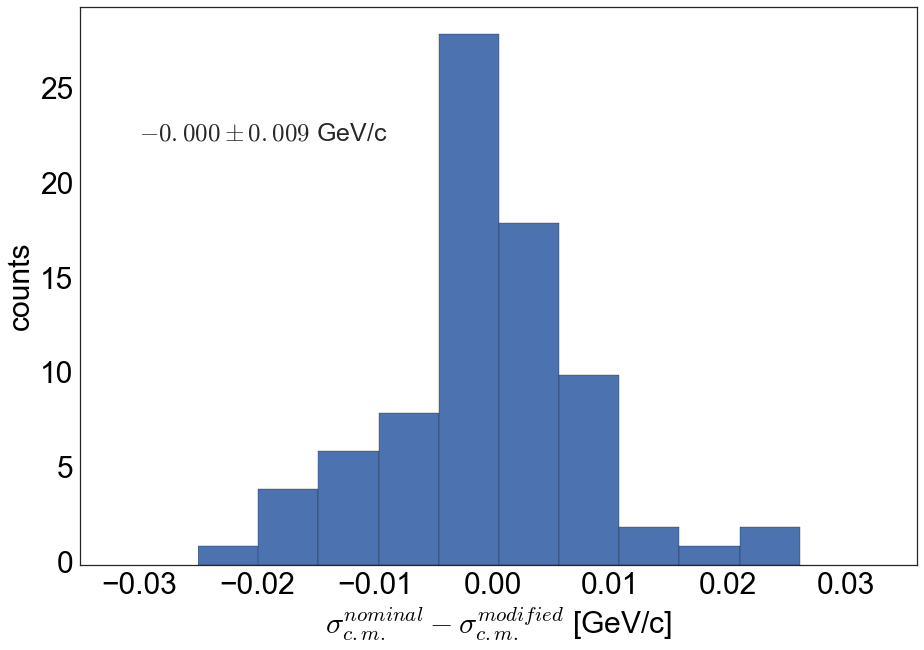

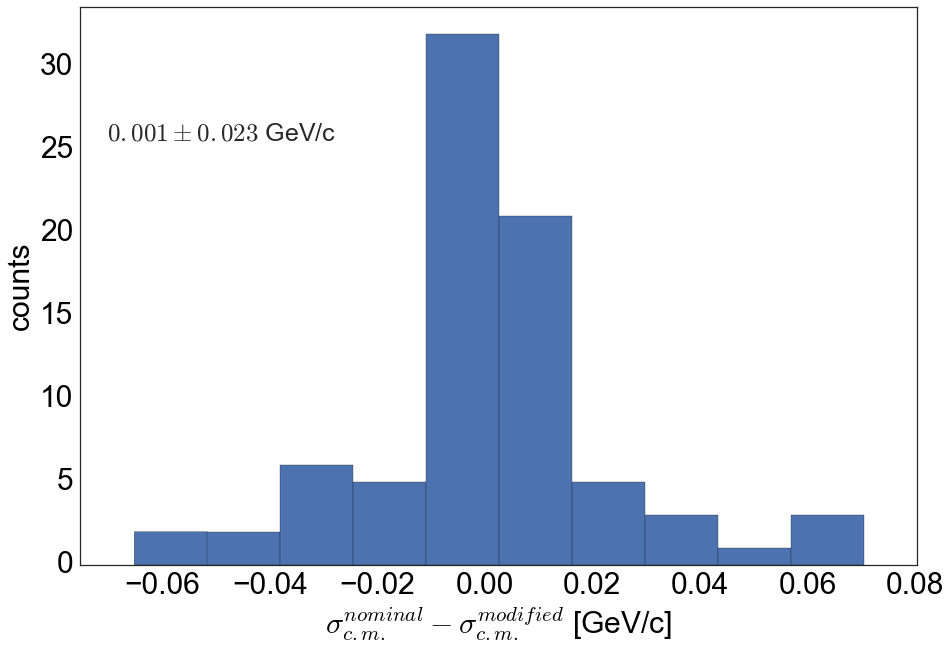

In [135]:
# total systematical uncertainty
hist_diff(cm_diff=df_cm_diff['C12'])
hist_diff(cm_diff=df_cm_diff['Al27'])
hist_diff(cm_diff=df_cm_diff['Fe56'])
hist_diff(cm_diff=df_cm_diff['Pb208'])

In [55]:
do_make_plot = True
do_save_plots = False
do_2_plots = True
do_4_plots = False
targets = ['C12']#,'Al27','Fe56','Pb208']
variables = ['sigma']#,'mean']
var_names = ["$\sigma_{c.m.}$ [GeV/c]"]#,"$\mu_{c.m.}$ [GeV/c]"]

for target in targets:
    print '-------\n',target,'\n-------'
    for var,var_label in zip(variables,var_names):
        print var
#         mean_Xb115 , sigma_Xb115 = fit_cm_nom_mod(Xbmin = [1.15,1.25],
#                                                   modified_cut_name='Xb115Xb125',
#                                                   nominal_and_modified_cut_names=['$x_B>1.2$','$x_B>1.15$','$x_B>1.25$'],
#                                                   target=target,do_prints=False,do_make_plot=do_make_plot,
#                                                   do_save_plots=do_save_plots,var=var,var_label=var_label)

# #         mean_Xb125 , sigma_Xb125 = fit_cm_nom_mod(Xbmin = 1.25,modified_cut_name='Xb125',    
# #                                                     nominal_and_modified_cut_names=['$x_B>1.2$','$x_B>1.25$'],
# #                                                 target=target,do_prints=False,do_make_plot=do_make_plot,
# #                                                 do_save_plots=do_save_plots,var=var,var_label=var_label)
# #         sensitivity_Xb = []
# #         for i,direction in zip(range(3),directions):
# #             a,b,a_err,b_err=mean_Xb115[i],sigma_Xb115[i],mean_Xb125[i] , sigma_Xb125[i]
# #             sensitivity_Xb.append(np.max(np.abs([a,b,a_err,b_err])))
# #             print [a,b,a_err,b_err]
# #             if i==2: print 'xB>1.2 %s(%s) cut sensitivity: %.1f'%(var,direction,sensitivity_Xb[-1])
# #         sensitivity_t_Xb = np.sqrt(np.square(sensitivity_Xb[0])+np.square(sensitivity_Xb[1]))
#         sensitivity_t_Xb = np.max([mean_Xb115 , sigma_Xb115])
#         print 'xB>1.2 %s(transverse) cut sensitivity: %.3f GeV/c'%(var,sensitivity_t_Xb)






        mean_theta_pq_20 , sigma_theta_pq_20 = fit_pp_cm_in_cut(theta_pq_max=[20,30],
                                                                modified_cut_name='theta_pq_20_theta_pq_30',   
                                                                nominal_and_modified_cut_names=['$\\theta_{pq}<25^{0}$','$\\theta_{pq}<20^{0}$','$\\theta_{pq}<30^{0}$'],
                                                                target=target,do_prints=False,do_make_plot=do_make_plot,
                                                                do_save_plots=do_save_plots,var=var,var_label=var_label)

#         mean_theta_pq_30 , sigma_theta_pq_30 = fit_pp_cm_in_cut(theta_pq_max=30,modified_cut_name='theta_pq_30',
#                                                                 nominal_and_modified_cut_names=['$\\theta_{pq}<25^{0}$','$\\theta_{pq}<30^{0}$'],
#                                                 target=target,do_prints=False,do_make_plot=do_make_plot,
#                                                 do_save_plots=do_save_plots,var=var,var_label=var_label)

#         sensitivity_theta_pq = []
#         for i,direction in zip(range(3),directions):
#             a,b,a_err,b_err=mean_theta_pq_20[i],sigma_theta_pq_20[i],mean_theta_pq_30[i] , sigma_theta_pq_30[i]
#             sensitivity_theta_pq.append(np.max(np.abs([a,b,a_err,b_err])))
# #             print [a,b,a_err,b_err]
#             if i==2: print 'theta_pq<25 %s(%s) cut sensitivity: %.1f'%(var,direction,sensitivity_theta_pq[-1])
#         sensitivity_t_theta_pq = np.sqrt(np.square(sensitivity_Xb[0])+np.square(sensitivity_theta_pq[1]))
        sensitivity_t_theta_pq = np.max([mean_theta_pq_20 , sigma_theta_pq_20])
        print 'theta_pq<25 %s(transverse) cut sensitivity: %.1f'%(var,sensitivity_t_theta_pq)



#         mean_p_over_q_057_091 , sigma_p_over_q_057_091 = fit_pp_cm_in_cut(p_over_q_min=0.57,
#                                                                 p_over_q_max=0.91,
#                                                                 modified_cut_name='p_over_q_057_091',
#                                                                           nominal_and_modified_cut_names=['$0.62<|p|/|q|<0.96$','$0.57<|p|/|q|<0.91$'],
#                                                 target=target,do_prints=False,do_make_plot=do_make_plot,
#                                                 do_save_plots=do_save_plots,var=var,var_label=var_label)


#         mean_p_over_q_067_101 , sigma_p_over_q_067_101 = fit_pp_cm_in_cut(p_over_q_min=0.67,
#                                                                 p_over_q_max=1.01,
#                                                                 modified_cut_name='p_over_q_067_101',
#                                                                           nominal_and_modified_cut_names=['$0.62<|p|/|q|<0.96$','$0.67<|p|/|q|<1.01$'],
#                                                 target=target,do_prints=False,do_make_plot=do_make_plot,
#                                                 do_save_plots=do_save_plots,var=var,var_label=var_label)
#         sensitivity_p_over_q=[]
#         for i,direction in zip(range(3),directions):
#             a,b,a_err,b_err=mean_p_over_q_057_091[i],sigma_p_over_q_057_091[i],mean_p_over_q_067_101[i] , sigma_p_over_q_067_101[i]
#             sensitivity_p_over_q.append(np.max(np.abs([a,b,a_err,b_err])))
# #             print [a,b,a_err,b_err]
#             if i==2: print '0.62<p/q<0.97 %s(%s) cut sensitivity: %.1f'%(var,direction,sensitivity_p_over_q[-1])
#         sensitivity_t_p_over_q = np.sqrt(np.square(sensitivity_Xb[0])+np.square(sensitivity_p_over_q[1]))
#         print '0.62<p/q<0.97 %s(transverse) cut sensitivity: %.1f'%(var,sensitivity_t_p_over_q)


 
#         mean_mmiss1050 , sigma_mmiss1050 = fit_pp_cm_in_cut(MmissMax=1.05,
#                                                             modified_cut_name='mmiss1050',           
#                                                             nominal_and_modified_cut_names=['$M_{miss}<1.1$ GeV/c$^2$','$M_{miss}<1.05$ GeV/c$^2$'],
#                                                 target=target,do_prints=False,do_make_plot=do_make_plot,
#                                                 do_save_plots=do_save_plots,var=var,var_label=var_label)

#         mean_mmiss1150 , sigma_mmiss1150 = fit_pp_cm_in_cut(MmissMax=1.15,
#                                                             modified_cut_name='mmiss1150',     
#                                                             nominal_and_modified_cut_names=['$M_{miss}<1.1$ GeV/c$^2$','$M_{miss}<1.15$ GeV/c$^2$'],
#                                                 target=target,do_prints=False,do_make_plot=do_make_plot,
#                                                 do_save_plots=do_save_plots,var=var,var_label=var_label)

#         sensitivity_mmiss = []
#         for i,direction in zip(range(3),directions):
#             a,b,a_err,b_err=mean_mmiss1050[i],sigma_mmiss1050[i],mean_mmiss1150[i] , sigma_mmiss1150[i]
#             sensitivity_mmiss.append(np.max(np.abs([a,b,a_err,b_err])))
# #             print [a,b,a_err,b_err]
#             if i==2: print 'Mmiss<1.1 %s(%s) cut sensitivity: %.1f'%(var,direction,sensitivity_mmiss[-1])
#         sensitivity_t_mmiss = np.sqrt(np.square(sensitivity_Xb[0])+np.square(sensitivity_mmiss[1]))
#         print 'Mmiss<1.1 %s(transverse) cut sensitivity: %.1f'%(var,sensitivity_t_mmiss)



#         print 'tot. syst. uncertainty tranverse ('+var+'): %.1f'%np.sqrt(np.square(sensitivity_t_Xb) 
#                                                                          + np.square(sensitivity_t_theta_pq)
#                                                                          + np.square(sensitivity_t_p_over_q) 
#                                                                          + np.square(sensitivity_t_mmiss))

#         if len(directions)>2:
#             print 'tot. syst. uncertainty longitudinal ('+var+'): %.1f'%np.sqrt(np.square(sensitivity_Xb[2]) 
#                                                                          + np.square(sensitivity_theta_pq[2])
#                                                                          + np.square(sensitivity_p_over_q[2]) 
#                                                                          + np.square(sensitivity_mmiss[2]))





    



-------
C12 
-------
sigma


ValueError: operands could not be broadcast together with shapes (1116,) (2,) 

In [19]:

def fit_pp_cm_in_cut(var='sigma',var_label="$\sigma_{c.m.}$ [GeV/c]",
                     Xbmin = 1.2,
                     theta_pq_max = 25 ,                     
                     p_over_q_min = 0.62 , p_over_q_max = 0.96 ,                      
                     MmissMax = 1.10 ,
                     modified_cut_name='Xb115',
                     nominal_and_modified_cut_names=['$x_B>1.2$','$x_B>1.15$'] , target='C12', 
                     do_prints=False,
                     do_make_plot=True,
                     do_save_plots=False):

    cm_nom,cm_mod = get_cm_parameters(target=target,
                                      Xbmin=Xbmin,
                                      theta_pq_max=theta_pq_max,
                                      p_over_q_min=p_over_q_min,p_over_q_max=p_over_q_max,
                                      MmissMax=MmissMax,
                                      do_prints=do_prints,
                                      cut_name=nominal_and_modified_cut_names[1])

    a , a_err , b , b_err , eta_cm , eta_cm_err = [] , [] , [] , [] , [] , []
    r_cm , r_cm_err = [] , [] 
    for direction in directions:   
        a.append(cm_nom[var+'_'+direction+'_unweighted'])
        b.append(cm_mod[var+'_'+direction+'_unweighted'] )
        a_err.append(cm_nom[var+'_'+direction+'Err_unweighted'])
        b_err.append(cm_mod[var+'_'+direction+'Err_unweighted'])
        eta_tmp , eta_err_tmp = eta( 1000*np.abs(b[-1]) , 1000*np.abs(a[-1]) )
        eta_cm.append(eta_tmp)
        eta_cm_err.append(eta_err_tmp)
        r_cm.append( b[-1]/a[-1] )
        r_cm_err.append( r_cm[-1]*np.sqrt( np.square(a_err[-1]/a[-1]) + np.square(b_err[-1]/b[-1]) ) )


    mean_eta , sigma_eta = [] , []

    if do_make_plot:
        fig = plt.figure(figsize=(16,21))
#         if do_2_plots is not True:
#             ax = fig.add_subplot(6,1,(1,3))
#         else:
#             ax = fig.add_subplot(2,1,1)
        ax = fig.add_subplot(3,1,1)
        for i,color,marker,direction in zip(range(len(a)),colors,markers,directions):
            plt.errorbar(Pmiss-0.01*(np.power(-1,i))*(i)*np.ones(len(Pmiss)), a[i], yerr=a_err[i],
                         color=color, marker=marker , linestyle='none' , label=None , markersize=10,alpha=0.2)
            plt.errorbar(Pmiss-0.008*(np.power(-1,i))*(i+1)*np.ones(len(Pmiss)), b[i], yerr=b_err[i],
                         color=color, marker=marker , linestyle='none' ,markersize=10,label='%s direction'%direction)
            
#         ymin, ymax = ax.get_ylim()
#         ax.yaxis.set_ticks(np.linspace(ymin, ymax, 5))

        #plt.text( xmin+0.2*(xmax-xmin) , ymin+0.5*(ymax-ymin), '%s vs. %s'%(nom_and_mod_cut_names[0],nom_and_mod_cut_names[1]) , fontsize=25)
        ax.grid()
        ax.legend(fontsize=25,loc='best')
        ax.set_title('%s vs. %s (%s)'%(nominal_and_modified_cut_names[0],nominal_and_modified_cut_names[1],var) , fontsize=25 , y=1.04)
        set_axes(ax,x_label='',y_label=var_label, fontsize=30)
        ax.xaxis.set_major_formatter( NullFormatter() )


#         if do_4_plots is not True:
#             ax = fig.add_subplot(6,1,(4,6))
#         if do_2_plots is True:
#             ax = fig.add_subplot(2,1,2)
        ax = fig.add_subplot(3,1,2)
        set_axes(ax,x_label=r'$|\vec{p}_{miss}|$ [GeV/c]',y_label="$\eta$ [%]", fontsize=30)
        ax.grid()


                
        for i,color,marker,direction in zip([0,1],colors,markers,directions):



            if do_4_plots is True and do_2_plots is not True:
                ax = fig.add_subplot(6,1,i+4)
                y_label = "$\eta_{%s}$"%direction+' [%]'
                ax.grid()
                ymin, ymax = ax.get_ylim()
                ax.set_ylim(ymin-1, ymax+1)
                ax.yaxis.set_ticks(np.linspace(ymin, ymax, 3))
                if i<2:
                    ax.xaxis.set_major_formatter( NullFormatter() )
                    x_label=''
                else:
                    x_label = r'$|\vec{p}_{miss}|$ [GeV/c]'
                set_axes(ax,x_label=x_label,y_label=y_label, fontsize=30)

            plt.errorbar(Pmiss, 100*eta_cm[i], yerr=100*eta_cm_err[i],
                         color=color, marker=marker , linestyle='none' , label=None , markersize=10)

            ymin, ymax = ax.get_ylim()
            ytext = ymin+0.05*(i+1)*(ymax-ymin) if i%2==0 else ymax-0.05*(i+1)*(ymax-ymin)

            
            # fit to constant
#             x , y , yerr = Pmiss , 100*eta_cm[i] , 100*eta_cm_err[i]
#             simga2_inverse = [1./np.square(yerr[i]) if yerr[i]>0.01 else 0.01 for i in range(len(x))]
#             mean = np.average(y , weights=simga2_inverse)
            mean , sigma = plot_fit2constant(x=Pmiss , y=100*eta_cm[i] , yerr=100*eta_cm_err[i] , color=color , ytext=ytext)


            mean_eta.append(mean)
#             sigma = np.sqrt(np.average(np.square(y-mean),weights=simga2_inverse))
            sigma_eta.append(sigma)
#             y , yerr = mean*np.ones(len(x)) , sigma*np.ones(len(x))  
#             plt.plot( x , y , '-',color=color)
#             plt.fill_between( x , y-yerr , y+yerr , color=color , alpha=0.1)
#             anchored_text.append(AnchoredText('$%.3f \\pm %.3f $'%(mean,sigma) + '%',loc=1+i,prop=dict(color=color, size=20)))
#             plt.text(0.35 , ytext , '$%.3f \\pm %.3f $'%(mean,sigma) + '%', color=color , fontsize=20) 
#             ax.annotate('annotate%d'%i,arrowprops=dict(facecolor=color, shrink=0.05))


#         ax.add_artist(anchored_text[0])
#         ax.add_artist(anchored_text[1])

        

        ax = fig.add_subplot(3,1,3)
        set_axes(ax,x_label=r'$|\vec{p}_{miss}|$ [GeV/c]',y_label="modified/nominal $\\sigma_{c.m.}$ [%]", fontsize=30)
        ax.grid()
        for i,color,marker,direction in zip([0,1],colors,markers,directions):
            y , yerr = 100*(r_cm[i]-1) , 100*r_cm_err[i]
            plt.errorbar(Pmiss, y , yerr=yerr,
                         color=color, marker=marker , linestyle='none' , label=None , markersize=10)

            ymin, ymax = ax.get_ylim()
            ytext = ymin+0.05*(i+1)*(ymax-ymin) if i%2==0 else ymax-0.05*(i+1)*(ymax-ymin)
            plot_fit2constant(x=Pmiss , y=y , yerr=yerr , color=color , ytext=ytext)






        plt.subplots_adjust(hspace=0)        
        plt.tight_layout()
        if do_save_plots:
            fig.savefig("/Users/erezcohen/Desktop/DataMining/AccCorr_ppSRCAnalysisNote/all_figures/cm_sensitivity/cm_sensitivity_%s_%s_%s.pdf"%(var,modified_cut_name,target))
        return mean_eta , sigma_eta

